
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [77]:
%matplotlib inline

In [78]:
from __future__ import print_function, division

from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

random.seed(0)
torch.manual_seed(0) # set seed to generate weights, for comparisons across different models
plt.ion()   # interactive mode

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [79]:
# Define the dataset class
directory = '\data\sg_food'
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [80]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet prior
    ])
}

data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val', 'test': 'test'}

# Define the dataset
selected_classes = [1,2,6,7,9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [1, 2, 6, 7, 9]
    name: ['Char Kway Teow', 'Chicken Rice', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata']


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



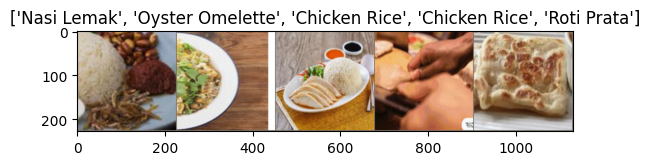

In [81]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])

imshow(out, title=[class_names[x] for x in classes[:5]])

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [82]:
def train_model(model, criterion, optimizer, scheduler, early_stop_patience, num_epochs):
    # TODO
    model = model.to(device)
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler:
                            scheduler.step(loss)
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model if validation loss has improved
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                
                # Reduce learning rate on plateau
                if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                    
                # Early stopping
                if epochs_without_improvement >= early_stop_patience:
                    print(f'Early stopping after {epoch+1} epochs with no improvement.')
                    model.load_state_dict(best_model_weights)
                    return model
                
    return model

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [83]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model = models.resnet18(pretrained=True)

# 2. Modify the pretrain model for your task.
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze last layer
for param in model.fc.parameters():
    param.requires_grad = True
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # Modify output layer for 5 classes

# 3. Choose your loss function, optimizer, etc.

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)




### 4.2 Printing and visualizing the modified model

In [84]:
# TODO
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [85]:
# TODO
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [86]:
# TODO 
start_time = time.time()
trained_model = train_model(model, criterion, optimizer, scheduler,  early_stop_patience=5, num_epochs=50)
end_time = time.time()
training_time_seconds = end_time - start_time
print(f"Total training time: {training_time_seconds:.2f} seconds")

Epoch 1/50
----------
Train Loss: 1.6822 Acc: 0.2340
Val Loss: 1.5436 Acc: 0.3733
Epoch 2/50
----------
Train Loss: 1.4819 Acc: 0.3540
Val Loss: 1.3482 Acc: 0.4867
Epoch 3/50
----------
Train Loss: 1.2925 Acc: 0.5060
Val Loss: 1.1909 Acc: 0.5867
Epoch 4/50
----------
Train Loss: 1.1784 Acc: 0.5900
Val Loss: 1.0487 Acc: 0.6867
Epoch 5/50
----------
Train Loss: 1.0772 Acc: 0.6540
Val Loss: 0.9750 Acc: 0.7067
Epoch 6/50
----------
Train Loss: 1.0062 Acc: 0.7080
Val Loss: 0.9680 Acc: 0.7000
Epoch 7/50
----------
Train Loss: 1.0160 Acc: 0.7020
Val Loss: 0.9647 Acc: 0.7000
Epoch 8/50
----------
Train Loss: 1.0318 Acc: 0.6800
Val Loss: 0.9647 Acc: 0.6933
Epoch 9/50
----------
Train Loss: 1.0355 Acc: 0.6760
Val Loss: 0.9658 Acc: 0.6933
Epoch 10/50
----------
Train Loss: 1.0302 Acc: 0.6820
Val Loss: 0.9653 Acc: 0.7000
Epoch 11/50
----------
Train Loss: 1.0143 Acc: 0.7020
Val Loss: 0.9610 Acc: 0.7067
Epoch 12/50
----------
Train Loss: 1.0371 Acc: 0.6600
Val Loss: 0.9632 Acc: 0.7000
Epoch 13/50
-

## 5. Loading test data

Define the dataset and dataloader for testing.

In [87]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

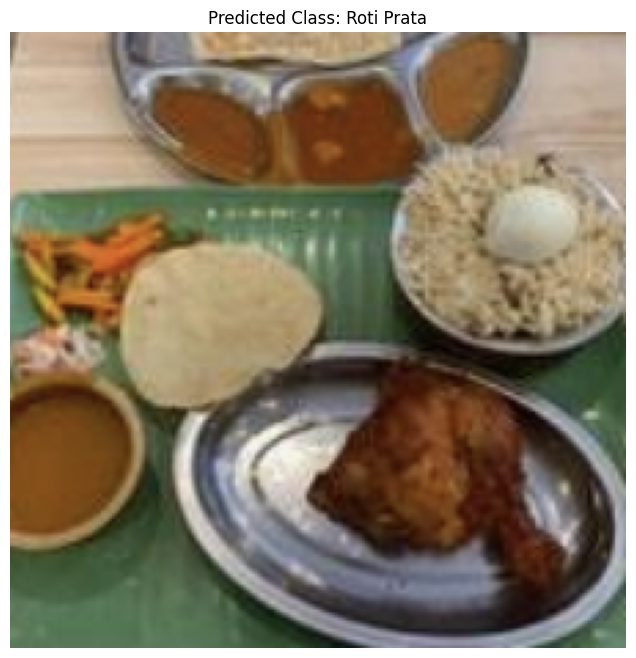

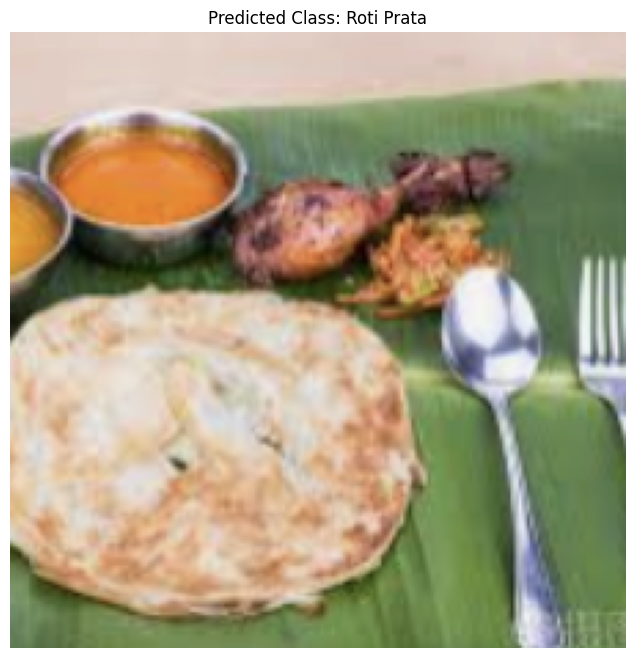

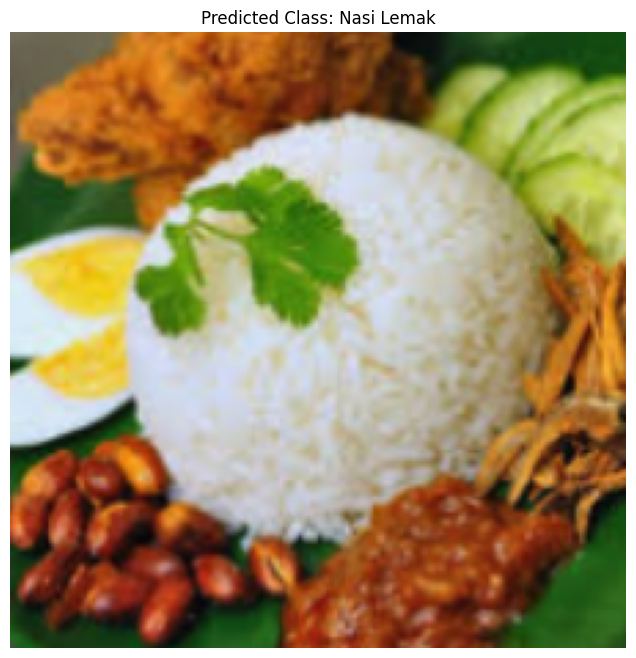

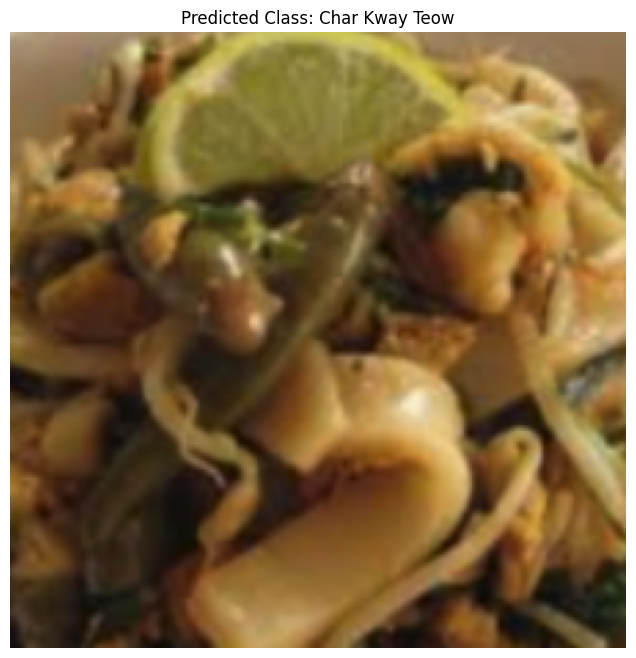

In [88]:
# TODO

# Define the number of images to predict
num_images = 4

test_loader = dataloaders['test']  # Use 'val' DataLoader as an example

# Set the model to evaluation mode
trained_model.eval()

# Iterate through the test dataloader to get the specified number of images
with torch.no_grad():
    count = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
        
        # Forward pass (make predictions)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Iterate over each image in the batch
        for i in range(inputs.size(0)):
            count += 1
            
            # Get the predicted label and convert to class name
            pred_label = preds[i].item()
            pred_class_name = class_names[pred_label]
            
            # Convert the input image tensor to numpy array for visualization
            input_image = inputs[i].cpu().numpy().transpose((1, 2, 0))
            input_image = input_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Un-normalize
            
            # Plot the image and predicted label
            plt.figure(figsize=(8, 8))
            plt.imshow(input_image)
            plt.title(f'Predicted Class: {pred_class_name}')
            plt.axis('off')
            plt.show()
            
            # Stop after predicting on the specified number of images
            if count >= num_images:
                break
        
        if count >= num_images:
            break

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.
OOD (detect image not in all classes) should only be done on the best model

In [89]:
trained_model.eval()

test_acc = 0
ood_threshold = 0  # Adjust this threshold, 0 to disable ood detection

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Predict on the test set
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels)

        # Softmax probabilities
        softmax_probs = F.softmax(outputs, dim=1)
        max_probs, _ = torch.max(softmax_probs, dim=1)
        
        # Determine OOD samples
        ood_mask = max_probs < ood_threshold
        ood_count = torch.sum(ood_mask).item()

    # Compute the testing accuracy
    test_acc = test_acc.double() / len(test_loader.dataset)
    print('Testing Acc: {:.4f}'.format(test_acc))
    print('Out-of-Distribution Samples: {}'.format(ood_count))


Evaluation
----------
Testing Acc: 0.7160
Out-of-Distribution Samples: 0
